In [1]:
#
# Runs the external program (DIFFaX) with the given input
# string as the input data file. Collects all possible
# DIFFaX outputs, returning a dictionary with the results,
# or raising an exception with a non-zero return code.
# All results are the raw outputs, except 'spc', which is
# parsed as the tab separated value file it is, and returned
# as a list of lists.
#
import subprocess
import os
import csv
from pathlib import Path
def runDIFFaXExt(inpdat, thmin=5.0, thmax=60.0, thstep=0.01, prefix="/tmp/DIFFaX", diffax_dir=Path(os.getcwd(),"DIFFaX_1813")):
    with open(prefix + ".inp","w") as f:
        f.write(inpdat)
    # DIFFaX doesnt overwrite files, so we need to
    # remove the output files before running this
    # instance of DIFFaX. We wrap in try blocks
    # in case files do not exist
    try:
        os.remove(prefix + ".spc")
    except FileNotFoundError:
        pass
    try:
        os.remove(prefix + ".dmp")
    except FileNotFoundError:
        pass
    try:
        os.remove(prefix + ".sym")
    except FileNotFoundError:
        pass
    #
    # We collect all verbose outputs (.dmp, .sym, .spc)
    #
    inp = """{ipf}
1
1
1
3
{thmin} {thmax} {thstep}
1
1
""".format(ipf=prefix+".inp",thmin=thmin,thmax=thmax,thstep=thstep)
    runans = subprocess.run([str(Path(diffax_dir,"DIFFaX"))], input=inp.encode("utf-8"), cwd=str(diffax_dir), capture_output=True, check=True)
    rv = {'inp': None, 'spc': None, 'dmp': None, 'sym': None, 'stdout': runans.stdout, 'stderr': runans.stderr}
    for k in rv.keys():
        try:
            if k == 'spc':
                with open(prefix + "." + k, "r", newline='') as f:
                    arr = []
                    opf = csv.reader(f, delimiter='\t')
                    for r in opf:
                        arr.append(r)
                    rv[k] = arr
            else:
                with open(prefix + "." + k, "r") as f:
                    rv[k] = f.read()
        except FileNotFoundError:
            pass
    return rv

In [2]:
#
# Run DIFFaX on the example/sample input file, as 
# a sanity check.
#
finp = """INSTRUMENTAL
X-RAY
1.5418
PSEUDO-VOIGT .89 -.32 .08 .6 trim
STRUCTURAL
2.52 2.52 2.06 120
6/MMM
2
LAYER 1
CENTROSYMMETRIC
C   1 -1/3 -1/6 -1/8 1 1
LAYER 2
CENTROSYMMETRIC
C   1 1/3 1/6 -1/8 1 1
STACKING
recursive
infinite
TRANSITIONS
.7 2/3 1/3 1
.3 0 0 1
.3 0 0 1
.7 -2/3 -1/3 1
"""
rv = runDIFFaXExt(finp)
for r in rv['stdout'].splitlines():
    print(r)

b' ***************************************************'
b' ***************************************************'
b' *                                                 *'
b' *  DDDD     II   FFFFFF   FFFFFF           X   X  *'
b' *  D   D    II   F        F        aaaa     X X   *'
b' *  D    D   II   FFFF     FFFF    a    a     X    *'
b' *  D   D    II   F        F       a   aa    X X   *'
b' *  DDDD     II   F        F        aaa a   X   X  *'
b' *                                                 *'
b' ***************************************************'
b' ****************** DIFFaX v1.813 ******************'
b' ***************************************************'
b' ***************** 19th May,  2010 *****************'
b' ***************************************************'
b' *                                                 *'
b' *   A computer program for calculating            *'
b' *   Diffraction Intensity From Faulted Crystals   *'
b' *                                            

<IPython.core.display.Javascript object>


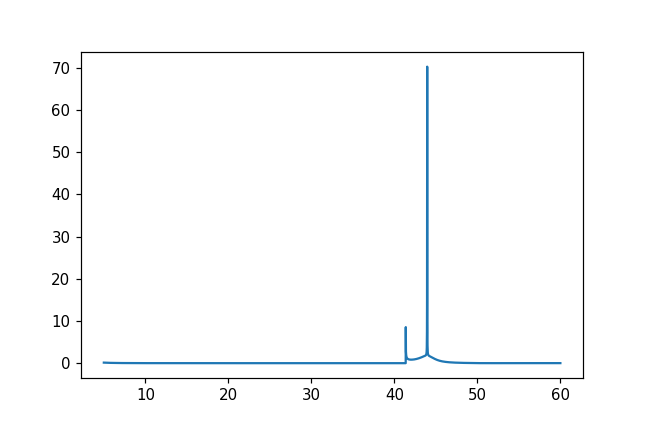

In [3]:
#
# Plot the sample DIFFaX output, as a sanity check.
#
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
pred = np.array(rv['spc'],dtype=np.float64)
plt.plot(pred[:,0],pred[:,1])

In [4]:
#
# This function constructs and executes a DIFFaX run for
# a given crystallographic input and ancillary parameters.
# For compatibility with a range of actual python structure
# implementations, expects inputs in a semi-processed form.
# Parameters:
# a,b,c = lattice parameters in angstroms, with "c" being the stacking axis
#         (perpendicular to a and b).
# gamma = angle between a and b.
# layers = list, containing atom info for each layer
# trans[i][j] = list of lists specifying the
#               transition probability and vector
#               for each i-j pair as a 4-tuple (prob,dx,dy,dz)
#               prob as a fraction, dx,dy,dz as fractions of a,b,c
# Each individual layer in layers is a list of tuples, containing:
#  (sym, x, y, z, Biso, occ)
# where sym is the atomic symbol, x,y,z are fractional coordinates, Biso
# is the thermal parameter, and occ is the occupancy. No symmetry is
# assumed in any layer, so *all* atoms must be included.
# If it is *not* the first layer, than this can also specify the index
# of the equivalent layer. That means:
#   layers[0] = [...]
#   layers[1] = 0
# would define layer 2 (=1) as the same as layer 1 (=0)
# Optional parameters:
# lam = wavelength in angstrom
# gu, gv, gw = gaussian u, v, w values
# **kwargs = extra arguments to pass to runDIFFaXExt
#
def runDIFFaX(a, b, c, gamma, layers, trans, lam=1.5418, gu=0.1, gv=-0.036, gw=0.009, **kwargs):
    abcga = "{a:.6f} {b:.6f} {c:.6f} {g:.3f}".format(a=a,b=b,c=c,g=gamma)
    inpdat = """INSTRUMENTAL
X-RAY
{lam:.6f}
GAUSSIAN {gu:.5f} {gv:.5f} {gw:.5f}
STRUCTURAL
{abcga}
UNKNOWN
{nl}""".format(lam=lam,gu=gu,gv=gv,gw=gw,abcga=abcga,nl=len(layers))
    l = 1
    for layer in layers:
        if isinstance(layer,int):
            inpdat += "\nLAYER {lnum} = 1".format(lnum=l)
        else:
            inpdat += "\nLAYER {lnum}\nNONE".format(lnum=l)
            n = 1
            for r in layer:
                inpdat += "\n{sym:4s} {n} {x:.6f} {y:.6f} {z:.6f} {Biso:.3f} {occ:.4f}".format(sym=r[0],n=n,x=r[1],y=r[2],z=r[3],Biso=r[4],occ=r[5])
                n += 1
        l += 1
    inpdat += """\nSTACKING
recursive
infinite
TRANSITIONS"""
    for i in range(0,len(trans)):
        for j in range(0,len(trans[i])):
            inpdat += "\n{prob} {dx:.6f} {dy:.6f} {dz:.6f}".format(prob=trans[i][j][0],dx=trans[i][j][1],dy=trans[i][j][2],dz=trans[i][j][3])
    return runDIFFaXExt(inpdat, **kwargs)

In [5]:
#
# Sample approach to read a CIF using the Atomic Simulation Environment
# and then compute the diffraction pattern using DIFFaX with two
# identical layers and random porbability of transitioning between
# them (this corresponds to no stacking faults, just for illustration)
#
import ase.io
nb3cl8 = ase.io.read('Nb3Cl8_300K.cif')
abcalbega = nb3cl8.get_cell_lengths_and_angles()
layer1 = []
for sym,xyz in zip(nb3cl8.get_chemical_symbols(),nb3cl8.get_scaled_positions()):
    layer1.append((sym,xyz[0],xyz[1],xyz[2],1.0,1.0))
layers = [layer1, 0]
trans = [[(0.5,0,0,1),(0.5,0,0,1)],[(0.5,0,0,1),(0.5,0,0,1)]]
rv = runDIFFaX(abcalbega[0],abcalbega[1],abcalbega[2],abcalbega[5],layers,trans,thmin=4,thmax=70,thstep=0.02)
for r in rv['stdout'].splitlines():
    print(r)

/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'monoclinic' is not interpreted for space group Spacegroup(164, setting=1). This may result in wrong setting!
  setting_name, spacegroup))


b' ***************************************************'
b' ***************************************************'
b' *                                                 *'
b' *  DDDD     II   FFFFFF   FFFFFF           X   X  *'
b' *  D   D    II   F        F        aaaa     X X   *'
b' *  D    D   II   FFFF     FFFF    a    a     X    *'
b' *  D   D    II   F        F       a   aa    X X   *'
b' *  DDDD     II   F        F        aaa a   X   X  *'
b' *                                                 *'
b' ***************************************************'
b' ****************** DIFFaX v1.813 ******************'
b' ***************************************************'
b' ***************** 19th May,  2010 *****************'
b' ***************************************************'
b' *                                                 *'
b' *   A computer program for calculating            *'
b' *   Diffraction Intensity From Faulted Crystals   *'
b' *                                            

<IPython.core.display.Javascript object>


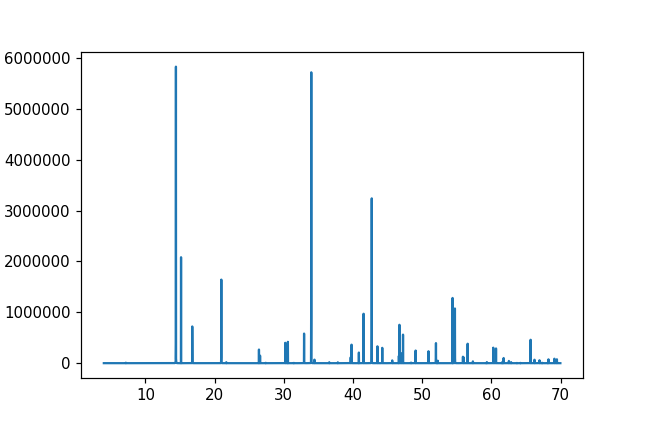

In [6]:
#
# Plot the sample DIFFaX output, as a sanity check.
#
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
pred = np.array(rv['spc'],dtype=np.float64)
plt.plot(pred[:,0],pred[:,1])